<a href="https://colab.research.google.com/github/Aleman-Z/StringerNeurons/blob/main/Neural_network_Stringer_stimulation_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependencies

## Loading of Stringer orientations data

includes some visualizations

In [ ]:
# @title Install depedencies
!pip install umap-learn --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data loading

dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [ ]:
# @title Reconstructing spontaneous period (useless since it has no angle data)

neural_data_spont=dat['u_spont'] @ dat['v_spont']
print(neural_data_spont.shape)

(23589, 910)


In [ ]:
# @title Dimensions of neural data during stimulation
print(dat['sresp'].shape)

(23589, 4598)


<ipython-input-49-facac8bc73e7>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


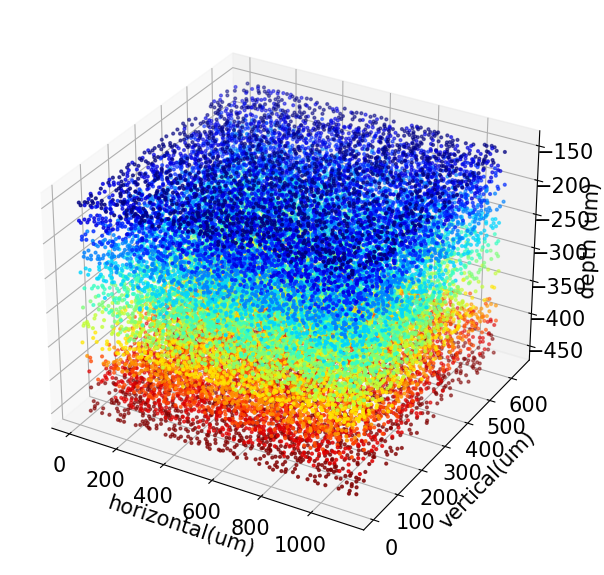

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

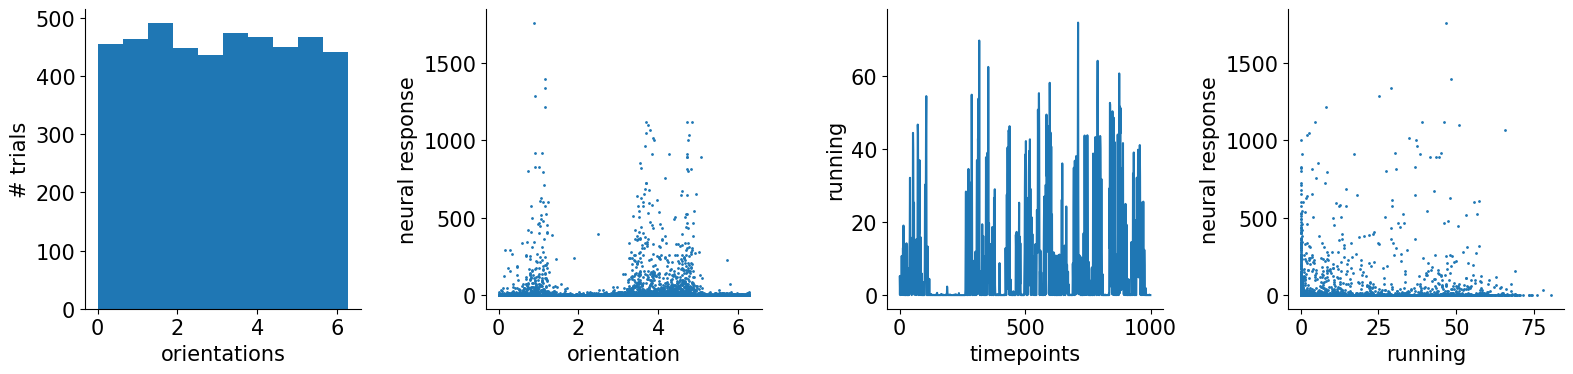

In [ ]:
# @title Basic data properties using plot, hist and scatter
ax = plt.subplot(1, 5, 1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel='# trials')

ax = plt.subplot(1, 5, 2)
plt.scatter(dat['istim'], dat['sresp'][200], s=1)
ax.set(xlabel='orientation', ylabel='neural response')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['run'][:1000])
ax.set(xlabel='timepoints', ylabel='running')

ax = plt.subplot(1, 5, 4)
plt.scatter(dat['run'], dat['sresp'][200], s=1)
ax.set(xlabel='running', ylabel='neural response')

plt.show()

(4598,)


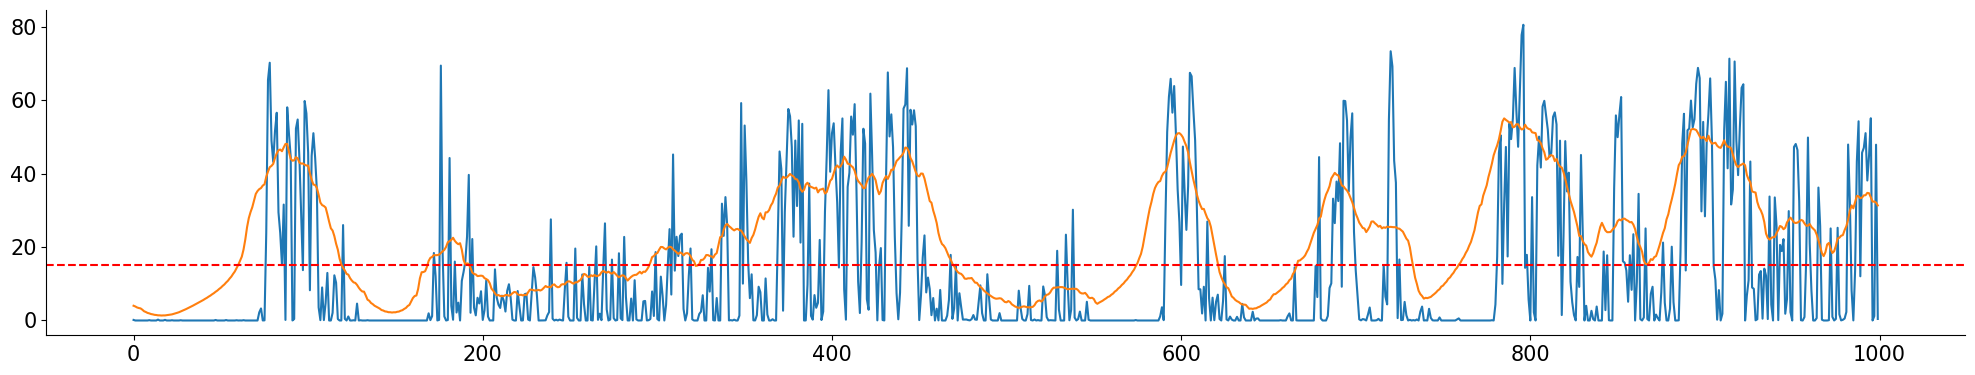

In [ ]:
# @title Smoothing running speed to identify high motion periods during stimuli condition (HMS).
run_data=dat['run']
print(run_data.shape)
plt.plot(run_data[2000:3000])
from scipy.signal import hilbert, convolve
analytic_signal = hilbert(run_data)
envelope = np.abs(analytic_signal)
window_size = 25
smoothed_envelope_HMS = convolve(envelope, np.ones(window_size) / window_size, mode='same')

plt.plot(smoothed_envelope_HMS[2000:3000])
# Add a horizontal line at Threshold
plt.axhline(y=15, color='r', linestyle='--', label='Horizontal Line at y=3')


Text(0.5, 1.0, 'Speed (raw and smoothed) during period of High motion activity')

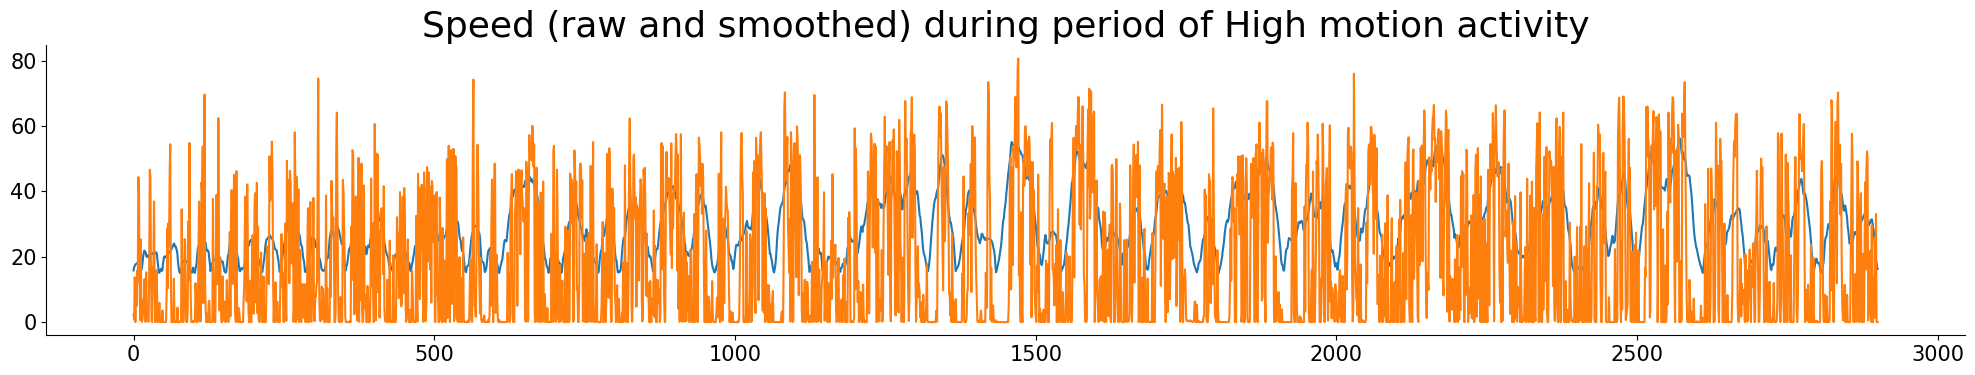

In [ ]:
# @title Thresholding speed to find high motion and low motion periods
threshold = 15
angle_data=dat['istim']

# Threshold the signal
above_threshold = smoothed_envelope_HMS > threshold
below_threshold= smoothed_envelope_HMS<=threshold

# Find the start and end indices of the periods above the threshold
start_indices = np.where(above_threshold & ~np.roll(above_threshold, 1))[0]
end_indices = np.where(above_threshold & ~np.roll(above_threshold, -1))[0]

start_indices_nonmotion = np.where(below_threshold & ~np.roll(below_threshold, 1))[0]
end_indices_nonmotion = np.where(below_threshold & ~np.roll(below_threshold, -1))[0]

# Handle edge case where the first or last point is above the threshold
if above_threshold[0]:
    start_indices = np.concatenate(([0], start_indices))
if above_threshold[-1]:
    end_indices = np.concatenate((end_indices, [len(smoothed_envelope_HMS) - 1]))

# Handle edge case where the first or last point is above the threshold
if below_threshold[0]:
    start_indices_nonmotion = np.concatenate(([0], start_indices_nonmotion))
if below_threshold[-1]:
    end_indices_nonmotion = np.concatenate((end_indices_nonmotion, [len(smoothed_envelope_HMS) - 1]))

# Create a concatenated signal with only the periods above the threshold
high_motion_smoothed_envelope = np.concatenate([smoothed_envelope_HMS[start:end+1] for start, end in zip(start_indices, end_indices)])
high_motion_run_data = np.concatenate([run_data[start:end+1] for start, end in zip(start_indices, end_indices)])
high_motion_angle_data = np.concatenate([angle_data[start:end+1] for start, end in zip(start_indices, end_indices)])



plt.plot(high_motion_smoothed_envelope)
plt.plot(high_motion_run_data)
plt.title('Speed (raw and smoothed) during period of High motion activity', fontsize=26)

(23589, 2901)
(23589,)


Text(0.5, 1.0, 'Mean activity across 23589 neurons during High motor period')

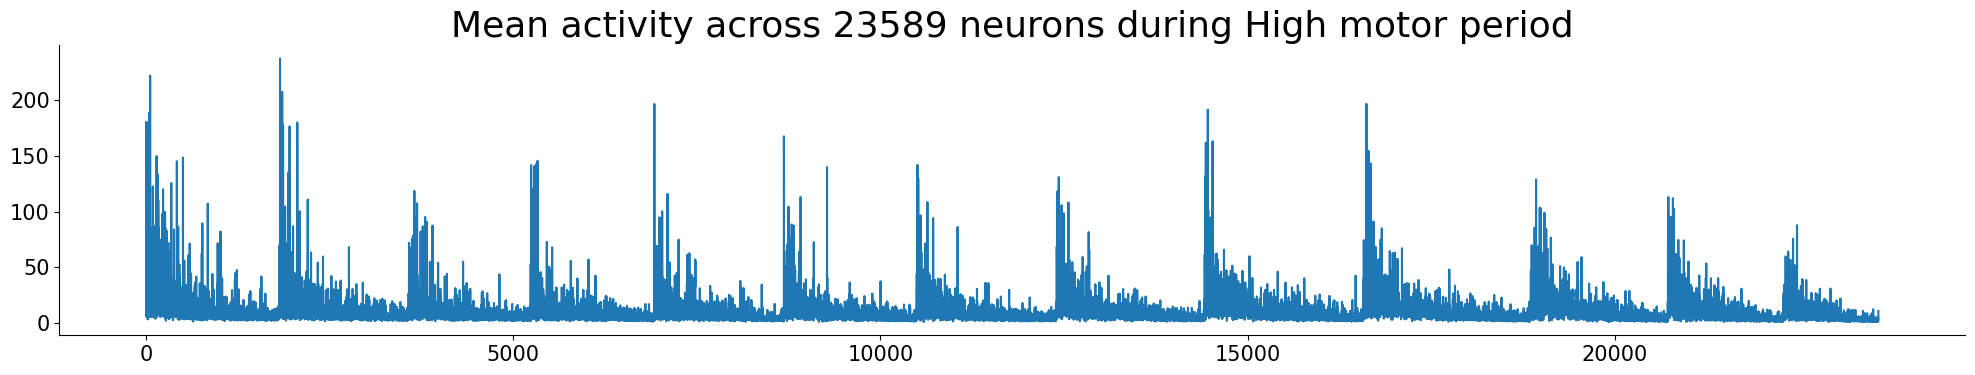

In [ ]:
# @title Extracting neural activity during high motor periods

neural_data=dat['sresp']
high_motor_neural_data = np.concatenate([neural_data[:, start:end+1] for start, end in zip(start_indices, end_indices)], axis=1)
print(high_motor_neural_data.shape)
high_motor_average=np.mean(high_motor_neural_data,axis=1)
print(high_motor_average.shape)
plt.plot(high_motor_average)
plt.title('Mean activity across 23589 neurons during High motor period', fontsize=26)

(23589, 1697)
(23589,)


Text(0.5, 1.0, 'Mean activity across 23589 neurons during Low motor period')

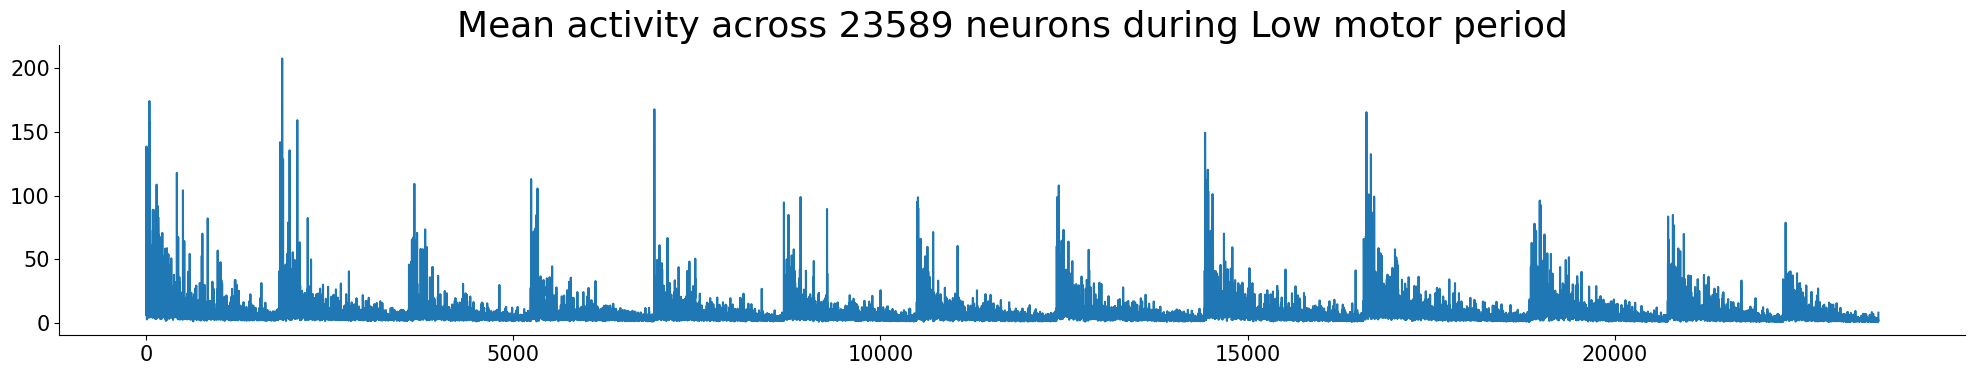

In [ ]:
angle_data=dat['istim']

non_motor_neural_data = np.concatenate([neural_data[:, start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=1)
non_motor_angle_data=np.concatenate([angle_data[start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=0)
print(non_motor_neural_data.shape)
#plt.plot(high_motor_neural_data[0,:])
non_motor_average=np.mean(non_motor_neural_data,axis=1)
print(non_motor_average.shape)
plt.plot(non_motor_average)
plt.title('Mean activity across 23589 neurons during Low motor period', fontsize=26)

Text(0.5, 1.0, 'Cortical Depth (Z)')

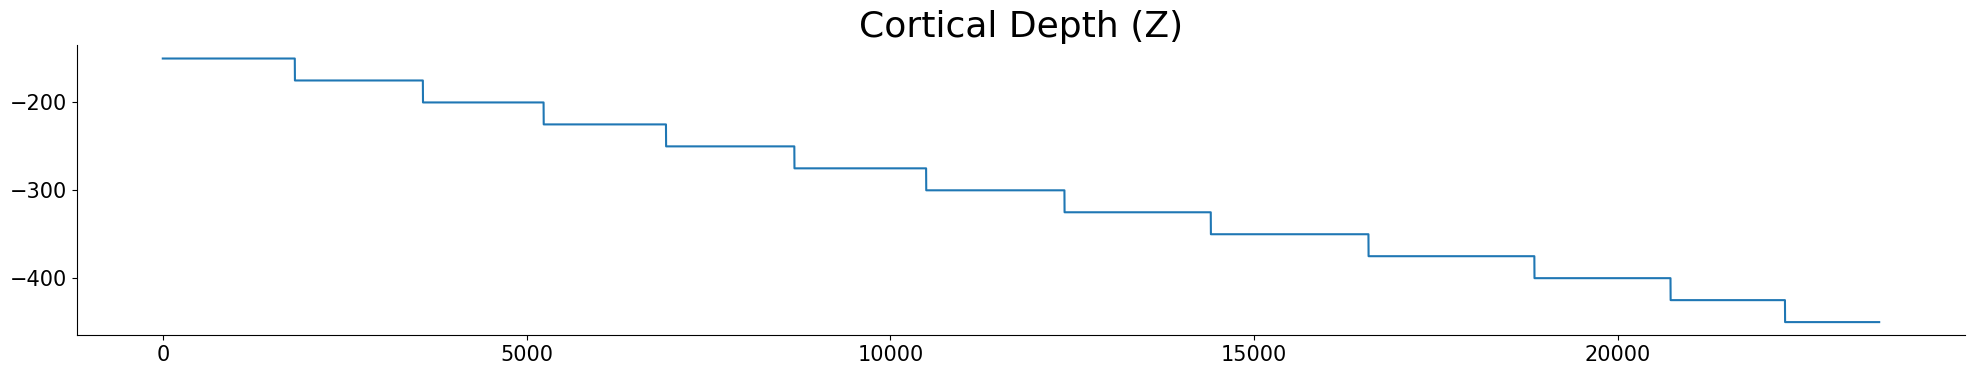

In [ ]:
plt.plot(z)
plt.title('Cortical Depth (Z)', fontsize=26)

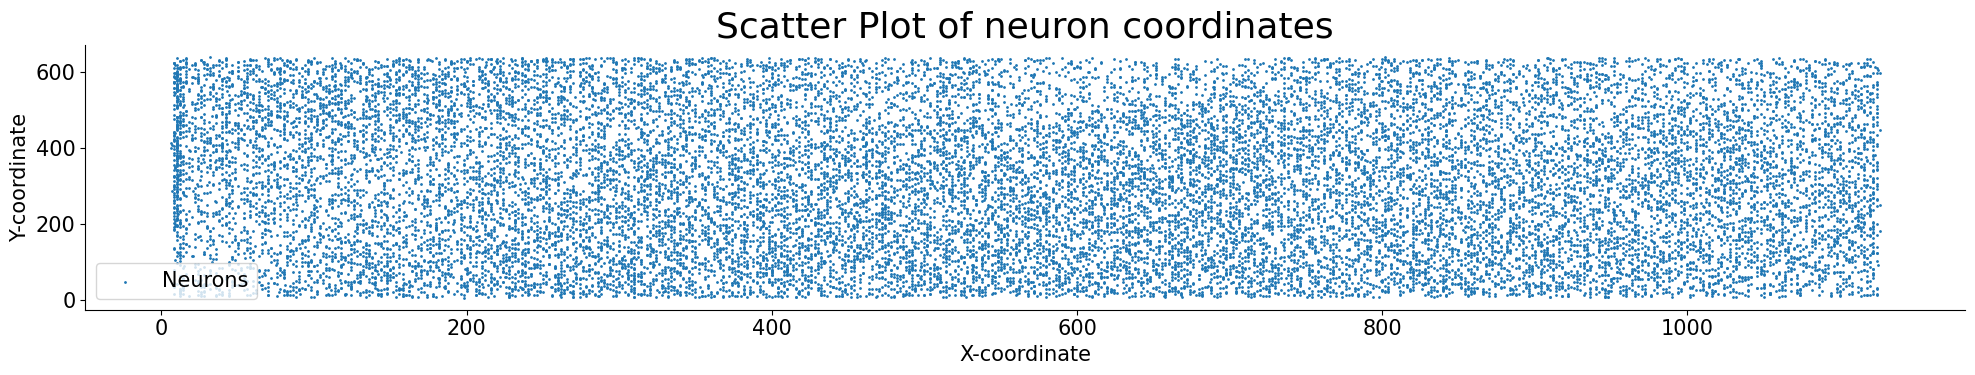

In [ ]:
# @title Distribution of X-Y coordinates

x,y,z=dat['xyz']
# Scatter plot of x-y coordinates
plt.scatter(x, y, label='Neurons',s=1)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Scatter Plot of neuron coordinates',fontsize=26)

# Show the plot
plt.legend()
plt.show()

(23589,)
[False False False ... False False False] 486


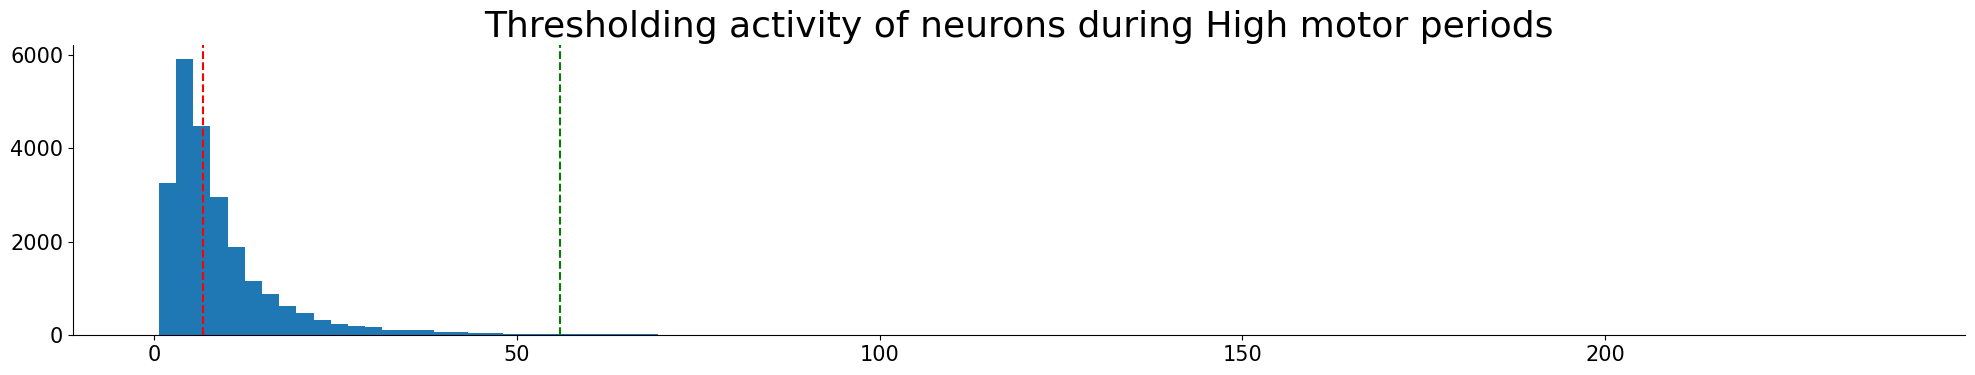

In [ ]:
# @title Finding neurons with high activity during High motion periods

plt.hist(high_motor_average,100)
plt.axvline(x=np.median(high_motor_average), color='r', linestyle='--', label='Vertical Line at y=25')
plt.axvline(x=np.median(high_motor_average)+np.std(high_motor_average)*4, color='g', linestyle='--', label='Vertical Line at y=25')
plt.title('Thresholding activity of neurons during High motor periods',fontsize=26)

threshold_motor_neurons=np.median(high_motor_average)+np.std(high_motor_average)*3
neurons_id=np.arange(0, 23590-1, 1)
print(neurons_id.shape)
# Threshold the neurons
above_threshold = high_motor_average > threshold_motor_neurons
print(above_threshold, np.sum(above_threshold))

motor_neurons=neurons_id[above_threshold]



(23589,)
[False False False ... False False False] 481


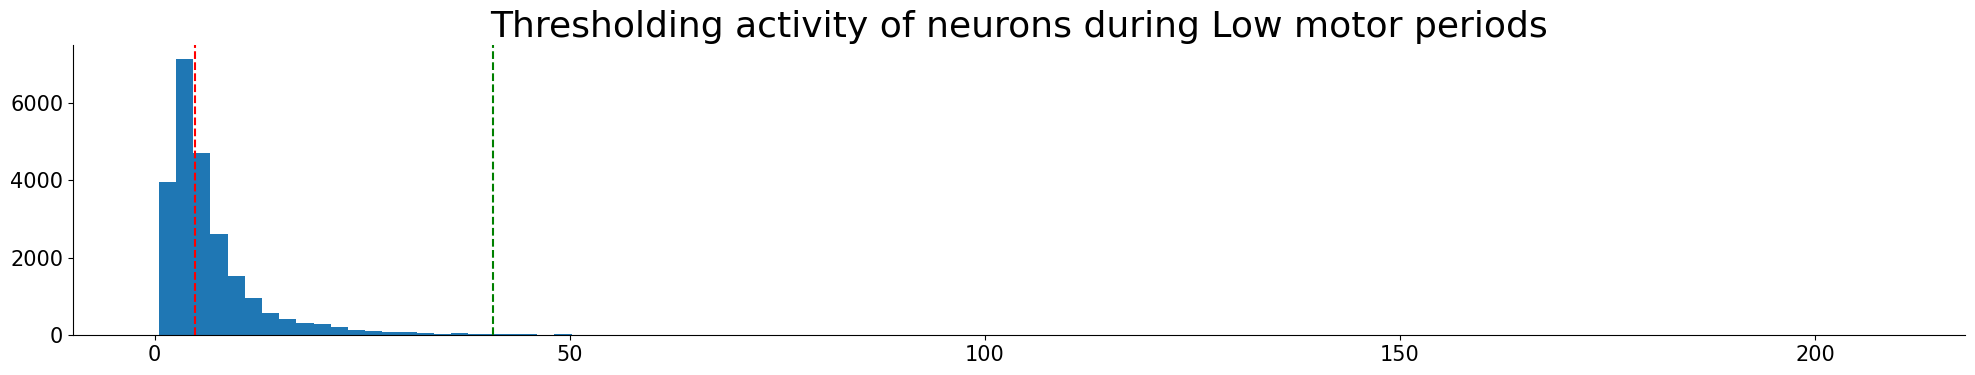

In [ ]:
# @title Finding neurons with high activity during Low motion periods

plt.hist(non_motor_average,100)
plt.axvline(x=np.median(non_motor_average), color='r', linestyle='--', label='Vertical Line at y=25')
plt.axvline(x=np.median(non_motor_average)+np.std(non_motor_average)*4, color='g', linestyle='--', label='Vertical Line at y=25')
plt.title('Thresholding activity of neurons during Low motor periods',fontsize=26)

threshold_non_motor_neurons=np.median(non_motor_average)+np.std(non_motor_average)*3
neurons_id_LMS=np.arange(0, 23590-1, 1)
print(neurons_id_LMS.shape)
# Threshold the neurons
above_threshold = non_motor_average > threshold_non_motor_neurons
print(above_threshold, np.sum(above_threshold))

LMS_neurons=neurons_id_LMS[above_threshold]

In [ ]:
# @title Finding common neurons in both High motion and Low motion periods
# Find common values
common_values = np.intersect1d(motor_neurons, LMS_neurons)
print(common_values.shape)
# Display the common values
#print("Common Values:", common_values)

# Find non-common values in array1
pure_motor_neurons = np.setdiff1d(motor_neurons, common_values)
print(pure_motor_neurons.shape)
#print(pure_motor_neurons)

pure_non_motor_neurons = np.setdiff1d(LMS_neurons, common_values)
print(pure_non_motor_neurons.shape)
#print(pure_non_motor_neurons)


(377,)
(109,)
(104,)


In [ ]:
pip install matplotlib_venn

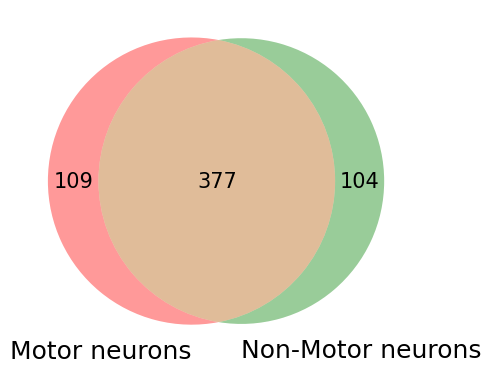

481


In [ ]:
# Set sizes of the groups in the Venn diagram
from matplotlib_venn import venn2
size_array1 = len(motor_neurons)
size_array2 = len(LMS_neurons)
size_common = len(common_values)

# Create a Venn diagram
venn2(subsets=(size_array1 - size_common, size_array2 - size_common, size_common),
      set_labels=('Motor neurons', 'Non-Motor neurons'))

# Display the plot
plt.show()
print(len(LMS_neurons))

In [ ]:
# @title remove common values to obtain pure motor neurons and pure non-motor neurons
LMS_neurons_wo_common = np.setdiff1d(LMS_neurons, common_values)
motor_neurons_wo_common = np.setdiff1d(motor_neurons, common_values)


377 common neurons with high activity independently of speed

In [ ]:
Z = zscore(non_motor_neural_data[LMS_neurons_wo_common], axis=1)
Z.shape

(104, 1697)

In [ ]:
# @title take PCA to obtain PC per neuron group

Z = zscore(non_motor_neural_data[LMS_neurons_wo_common], axis=1)
X_non_motor = PCA(n_components=20).fit_transform(Z.T)


Z = zscore(high_motor_neural_data[motor_neurons_wo_common], axis=1)
X_motor = PCA(n_components=20).fit_transform(Z.T)


Z = zscore(non_motor_neural_data[common_values], axis=1)
X_common_non_motor = PCA(n_components=20).fit_transform(Z.T)

Z = zscore(high_motor_neural_data[common_values], axis=1)
X_common_motor = PCA(n_components=20).fit_transform(Z.T)


4 PCA's:


*   Motor neurons (X_motor)
*   Non-motor neurons (X_non_motor)
*   Common neurons during High Motor periods (X_common_motor)
*   Common neurons during Low Motor periods (X_common_non_motor)




In [ ]:
#Motor
# @title motion neurons: We iterate across the 20 PCs to find the one with the highest correlation to the running speed
pc_highestcorr=0;
for i in range(20):
  xx=np.abs(np.corrcoef(high_motion_run_data,X_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(high_motion_run_data,X_motor[:,pc_ind])[1,0])
X_motor_pc=X_motor[:,pc_ind]

0
0.6918544635462487


In [ ]:
print(X_motor.shape)
print(high_motion_run_data.shape)

(2901, 20)
(2901,)


In [ ]:
#Non-Motor
# @title Non-Motor neurons: We iterate across the 20 PCs to find the one with the highest correlation to the stimulation angle
pc_highestcorr=0;
for i in range(20):
  xx=np.abs(np.corrcoef(non_motor_angle_data,X_non_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(non_motor_angle_data,X_non_motor[:,pc_ind])[1,0])
X_non_motor_pc=X_non_motor[:,pc_ind]

1
0.39131728644880626


In [ ]:
print(X_non_motor.shape)
print(non_motor_angle_data.shape)

(1697, 20)
(1697,)


In [ ]:
#Motor
# @title Common neurons during High Motor period: We iterate across the 20 PCs to find the one with the highest correlation to the running speed
pc_highestcorr=0;
for i in range(20):
  xx=np.abs(np.corrcoef(high_motion_run_data,X_common_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(high_motion_run_data,X_common_motor[:,pc_ind])[1,0])
X_common_motor_pc=X_common_motor[:,pc_ind]

5
0.5227919838953998


In [ ]:
print(X_common_motor.shape)
print(high_motion_run_data.shape)

(2901, 20)
(2901,)


In [ ]:
#Non Motion
# @title Common neurons during Low Motor period: We iterate across the 20 PCs to find the one with the highest correlation to the stimulation angle
pc_highestcorr=0;
for i in range(20):
  xx=np.abs(np.corrcoef(non_motor_angle_data,X_common_non_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(non_motor_angle_data,X_common_non_motor[:,pc_ind])[1,0])
X_common_non_motor_pc=X_common_non_motor[:,pc_ind]*-1 #Multiplied by -1 to reverse correlation sign

5
-0.387322682463315


4 PC's per neuron type (Selected based on correlation with speed or angle):


*   Motor neurons (X_motor_pc)
*   Non-motor neurons (X_non_motor_pc)
*   Common neurons during High Motor periods (X_common_motor_pc)
*   Common neurons during Low Motor periods (X_common_non_motor_pc)



In [ ]:
print(X_motor_pc.shape)
print(X_non_motor_pc.shape)
print(X_common_motor_pc.shape)
print(X_common_non_motor_pc.shape)


(2901,)
(1697,)
(2901,)
(1697,)


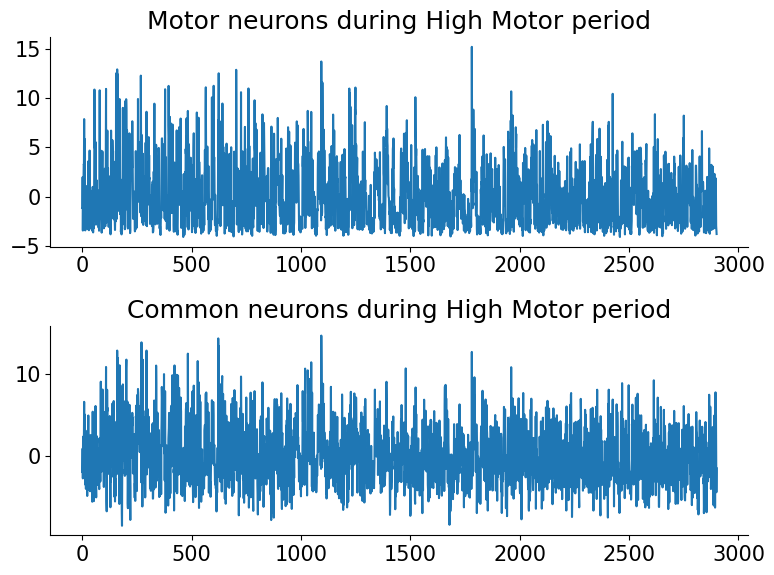

0.7182179357891896


In [ ]:
# @title Motor and common neurons during High motor period
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the data in the first subplot
axs[0].plot(X_motor_pc)
axs[0].set_title('Motor neurons during High Motor period')

# Plot the data in the second subplot
axs[1].plot(X_common_motor_pc)
axs[1].set_title('Common neurons during High Motor period')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
print(np.corrcoef(X_motor_pc,X_common_motor_pc)[1,0])

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linear_reg(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size=0.2, random_state=42)
  #print("X_train",X_train.shape)
  #print("y_train",y_train.shape)
  # Initialize and train the model
  model = LinearRegression()
  model.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
  # Make predictions on the test set
  predictions = model.predict(X_test.reshape(-1, 1))

  # Evaluate the model
  mse = mean_squared_error(y_test, predictions)
  #print(f"Mean Squared Error: {mse}")
  return(mse)

mse_motor=linear_reg(high_motion_run_data,X_motor_pc)
mse_common_motor=linear_reg(high_motion_run_data,X_common_motor_pc)
print('MSE motor neurons trained with running speed (Linear Regression):',mse_motor)
print('MSE common neurons during High motion period trained with running speed (Linear Regression):',mse_common_motor)



MSE motor neurons trained with running speed (Linear Regression): 4.804716586514485
MSE common neurons during High motion period trained with running speed (Linear Regression): 9.192295777237904


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def poli_reg(X, y, degree):
    X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size=0.2, random_state=42)

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train.reshape(-1, 1))
    X_poly_test = poly.transform(X_test.reshape(-1, 1))

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_poly_train, y_train.reshape(-1, 1))

    # Make predictions
    predictions = model.predict(X_poly_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    return mse

# Example usage with degree=2
degree = 2
mse_poli_2_motor = poli_reg(high_motion_run_data, X_motor_pc, degree)
mse_poli_2_common_motor=linear_reg(high_motion_run_data,X_common_motor_pc)

degree = 5
mse_poli_3_motor = poli_reg(high_motion_run_data, X_motor_pc, degree)
mse_poli_3_common_motor=linear_reg(high_motion_run_data,X_common_motor_pc)

print("MSE motor neurons trained with running speed (Polynomial Regression, degree=2):", mse_poli_2_motor)
print("'MSE common neurons trained with running speed (Polynomial Regression, degree=2):", mse_poli_2_common_motor)


MSE motor neurons trained with running speed (Polynomial Regression, degree=2): 4.2640479935109585
'MSE common neurons trained with running speed (Polynomial Regression, degree=2): 9.192295777237904


In [ ]:
print('MSE motor neurons trained with running speed (Linear Regression):',mse_motor)
print('MSE common neurons during High motion period trained with running speed (Linear Regression):',mse_common_motor)
print("MSE motor neurons trained with running speed (Polynomial Regression, degree=2):", mse_poli_2_motor)
print("'MSE common neurons trained with running speed (Polynomial Regression, degree=2):", mse_poli_2_common_motor)
print("MSE motor neurons trained with running speed (Polynomial Regression, degree=3):", mse_poli_3_motor)
print("'MSE common neurons trained with running speed (Polynomial Regression, degree=3):", mse_poli_3_common_motor)


MSE motor neurons trained with running speed (Linear Regression): 4.804716586514485
MSE common neurons during High motion period trained with running speed (Linear Regression): 9.192295777237904
MSE motor neurons trained with running speed (Polynomial Regression, degree=2): 4.2640479935109585
'MSE common neurons trained with running speed (Polynomial Regression, degree=2): 9.192295777237904
MSE motor neurons trained with running speed (Polynomial Regression, degree=3): 4.997408244179115
'MSE common neurons trained with running speed (Polynomial Regression, degree=3): 9.192295777237904


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def poli_reg2D(X, y, degree):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    print("X train:", X_train.shape)
    X_poly_train = poly.fit_transform(X_train)  # No need to transpose X_train
    X_poly_test = poly.transform(X_test)  # No need to transpose X_test

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_poly_train, y_train.reshape(-1, 1))

    # Make predictions
    predictions = model.predict(X_poly_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    return mse

# Example usage with degree=2
degree = 2

# Assuming high_motor_run_data and high_motor_angle_data have the same number of rows
high_motor_combined = np.vstack((high_motion_run_data, high_motion_angle_data)).T
X_motor_pc = X_motor_pc.reshape(-1)  # Remove unnecessary singleton dimension

print("High Motor Combined Shape:", high_motor_combined.shape)
print("X_motor_pc Shape:", X_motor_pc.shape)

mse_poli2D_motor = poli_reg2D(high_motor_combined, X_motor_pc, degree)
print("Mean Squared Error:", mse_poli2D_motor)

mse_poli2D_common_motor = poli_reg2D(high_motor_combined, X_common_motor_pc, degree)
print("Mean Squared Error:", mse_poli2D_common_motor)



High Motor Combined Shape: (2901, 2)
X_motor_pc Shape: (2901,)
X train: (2320, 2)
Mean Squared Error: 4.383492529616313
X train: (2320, 2)
Mean Squared Error: 6.842529967209041


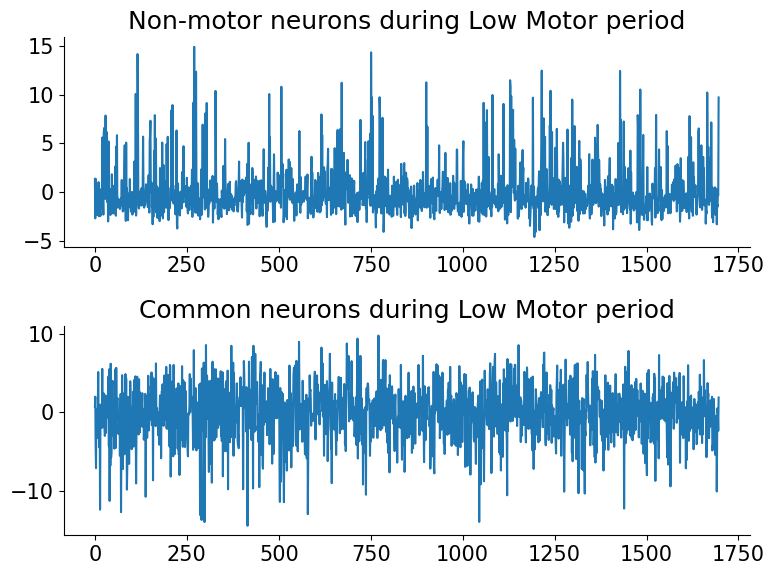

0.16649129740343643


In [ ]:
# @title Non-motion and common neurons during Low motion period
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the data in the first subplot
axs[0].plot(X_non_motor_pc)
axs[0].set_title('Non-motor neurons during Low Motor period')

# Plot the data in the second subplot
axs[1].plot(X_common_non_motor_pc)
axs[1].set_title('Common neurons during Low Motor period')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
print(np.corrcoef(X_non_motor_pc,X_common_non_motor_pc)[1,0])

# Neural Network

In [ ]:
# @title Imports and Dataset Split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Combine data
high_motion_combined = np.vstack((high_motion_run_data, high_motion_angle_data)).T
non_motion_combined = np.vstack((non_motor_neural_data, non_motor_angle_data)).T

# Split the data into training and testing sets
datasets = {
    "motor_pc": (high_motion_combined, X_motor_pc),
    "common_motor_pc": (high_motion_combined, X_common_motor_pc),
    "non_motor_pc": (non_motion_combined, X_non_motor_pc),
    "common_non_motor_pc": (non_motion_combined, X_common_non_motor_pc)
}

# Create a dictionary to store the training data
train_data = {}

for name, (X, Y) in datasets.items():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=29)
    X_train, Y_train = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float()
    print(f"X_train_{name} shape:", X_train.shape)
    print(f"Y_train_{name} shape:", Y_train.shape)

    # Store the training data in the dictionary
    train_data[name] = X_train

# Create networks for each case
for name, data in train_data.items():
    neuron_input = data.shape[1]
    print(f"Network for X_train_{name}:")
    print(neuron_input)

X_train_motor_pc shape: torch.Size([2320, 2])
Y_train_motor_pc shape: torch.Size([2320])
X_train_common_motor_pc shape: torch.Size([2320, 2])
Y_train_common_motor_pc shape: torch.Size([2320])
X_train_non_motor_pc shape: torch.Size([1357, 23590])
Y_train_non_motor_pc shape: torch.Size([1357])
X_train_common_non_motor_pc shape: torch.Size([1357, 23590])
Y_train_common_non_motor_pc shape: torch.Size([1357])
Network for X_train_motor_pc:
2
Network for X_train_common_motor_pc:
2
Network for X_train_non_motor_pc:
23590
Network for X_train_common_non_motor_pc:
23590


In [ ]:
# @title Neural Network Structure

class Net(nn.Module):
    def __init__(self, input_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_neurons, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create networks for each case
for name, (X, Y) in datasets.items():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=29)
    X_train, Y_train = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float()

    neuron_input = X_train.shape[1]
    net = Net(neuron_input)
    print(f"Network for X_train_{name}:")
    print(neuron_input)

Network for X_train_motor_pc:
2
Network for X_train_common_motor_pc:
2
Network for X_train_non_motor_pc:
23590
Network for X_train_common_non_motor_pc:
23590


In [ ]:
# @title Dataset Split
# Combine data
high_motion_combined = np.vstack((high_motion_run_data, high_motion_angle_data)).T
non_motion_combined = np.vstack((non_motor_neural_data, non_motor_angle_data)).T

# Split the data into training and testing sets
datasets = {
    "motor_pc": (high_motion_combined, X_motor_pc),
    "common_motor_pc": (high_motion_combined, X_common_motor_pc),
    "non_motor_pc": (non_motion_combined, X_non_motor_pc),
    "common_non_motor_pc": (non_motion_combined, X_common_non_motor_pc)
}

# Create a dictionary to store the training data
train_data = {}

for name, (X, Y) in datasets.items():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=29)
    X_train, Y_train = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float()
    print(f"X_train_{name} shape:", X_train.shape)
    print(f"Y_train_{name} shape:", Y_train.shape)

    # Store the training data in the dictionary
    train_data[name] = X_train

# Create networks for each case
for name, data in train_data.items():
    neuron_input = data.shape[1]
    net = Net(neuron_input)
    print(f"Network for X_train_{name}:")
    print(neuron_input)

X_train_motor_pc shape: torch.Size([2320, 2])
Y_train_motor_pc shape: torch.Size([2320])
X_train_common_motor_pc shape: torch.Size([2320, 2])
Y_train_common_motor_pc shape: torch.Size([2320])
X_train_non_motor_pc shape: torch.Size([1357, 23590])
Y_train_non_motor_pc shape: torch.Size([1357])
X_train_common_non_motor_pc shape: torch.Size([1357, 23590])
Y_train_common_non_motor_pc shape: torch.Size([1357])
Network for X_train_motor_pc:
2
Network for X_train_common_motor_pc:
2
Network for X_train_non_motor_pc:
23590
Network for X_train_common_non_motor_pc:
23590


In [ ]:
# @title Custom Dataset

class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create datasets and loaders for each case
for name, (X, Y) in datasets.items():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=29)
    X_train, Y_train = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float()

    dataset_train = MyDataset(X_train, Y_train)
    loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)

    dataset_test = MyDataset(X_test, Y_test)
    loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

    print(f"DataLoader for X_train_{name} created.")

DataLoader for X_train_motor_pc created.
DataLoader for X_train_common_motor_pc created.
DataLoader for X_train_non_motor_pc created.
DataLoader for X_train_common_non_motor_pc created.


In [ ]:
# @title Training Loop

# Define the criterion
criterion = nn.MSELoss()

# Create networks, optimizers, and training loops for each case
num_epochs = 10
test_datasets = {}  # To store the test datasets for later use
for name, (X, Y) in datasets.items():
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=29)
    X_train, Y_train = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float()
    test_datasets[name] = (X_test, Y_test)  # Save the test datasets

    # Define the neural network and optimizer
    neuron_input = X_train.shape[1]
    net = Net(neuron_input)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Create dataset and loader for training
    dataset_train = MyDataset(X_train, Y_train)
    loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(loader_train):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            print(f"Net_{name} - Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item():.4f}")

    # Optionally, you can evaluate on the test set after training
    X_test, Y_test = torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float()
    dataset_test = MyDataset(X_test, Y_test)
    loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

    with torch.no_grad():
        for inputs, labels in loader_test:
            outputs = net(inputs)
            test_loss = criterion(outputs, labels)
        print(f"Net_{name} - Test Loss: {test_loss.item():.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net_motor_pc - Epoch: 1, Batch: 1, Loss: 15.9756
Net_motor_pc - Epoch: 1, Batch: 2, Loss: 11.2633
Net_motor_pc - Epoch: 1, Batch: 3, Loss: 9.5251
Net_motor_pc - Epoch: 1, Batch: 4, Loss: 11.2981
Net_motor_pc - Epoch: 1, Batch: 5, Loss: 8.5197
Net_motor_pc - Epoch: 1, Batch: 6, Loss: 10.7880
Net_motor_pc - Epoch: 1, Batch: 7, Loss: 14.7638
Net_motor_pc - Epoch: 1, Batch: 8, Loss: 10.9683
Net_motor_pc - Epoch: 1, Batch: 9, Loss: 9.3313
Net_motor_pc - Epoch: 1, Batch: 10, Loss: 6.3158
Net_motor_pc - Epoch: 1, Batch: 11, Loss: 9.5973
Net_motor_pc - Epoch: 1, Batch: 12, Loss: 13.6004
Net_motor_pc - Epoch: 1, Batch: 13, Loss: 6.3473
Net_motor_pc - Epoch: 1, Batch: 14, Loss: 12.5920
Net_motor_pc - Epoch: 1, Batch: 15, Loss: 10.4513
Net_motor_pc - Epoch: 1, Batch: 16, Loss: 13.1262
Net_motor_pc - Epoch: 1, Batch: 17, Loss: 5.4974
Net_motor_pc - Epoch: 1, Batch: 18, Loss: 11.0039
Net_motor_pc - Epoch: 1, Batch: 19, Loss: 12.0868
Net_motor_pc - Epoch: 1, Batch: 20, Loss: 5.2140
Net_motor_pc - Ep

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net_motor_pc - Epoch: 2, Batch: 18, Loss: 9.7614
Net_motor_pc - Epoch: 2, Batch: 19, Loss: 12.2371
Net_motor_pc - Epoch: 2, Batch: 20, Loss: 11.0477
Net_motor_pc - Epoch: 2, Batch: 21, Loss: 11.3310
Net_motor_pc - Epoch: 2, Batch: 22, Loss: 8.7778
Net_motor_pc - Epoch: 2, Batch: 23, Loss: 8.0904
Net_motor_pc - Epoch: 2, Batch: 24, Loss: 8.4955
Net_motor_pc - Epoch: 2, Batch: 25, Loss: 7.5258
Net_motor_pc - Epoch: 2, Batch: 26, Loss: 5.5322
Net_motor_pc - Epoch: 2, Batch: 27, Loss: 6.2957
Net_motor_pc - Epoch: 2, Batch: 28, Loss: 12.1604
Net_motor_pc - Epoch: 2, Batch: 29, Loss: 6.6627
Net_motor_pc - Epoch: 2, Batch: 30, Loss: 5.6772
Net_motor_pc - Epoch: 2, Batch: 31, Loss: 8.4798
Net_motor_pc - Epoch: 2, Batch: 32, Loss: 14.1616
Net_motor_pc - Epoch: 2, Batch: 33, Loss: 10.9764
Net_motor_pc - Epoch: 2, Batch: 34, Loss: 17.3615
Net_motor_pc - Epoch: 2, Batch: 35, Loss: 12.8203
Net_motor_pc - Epoch: 2, Batch: 36, Loss: 18.3294
Net_motor_pc - Epoch: 2, Batch: 37, Loss: 11.5009
Net_motor_

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net_common_motor_pc - Epoch: 1, Batch: 50, Loss: 20.4009
Net_common_motor_pc - Epoch: 1, Batch: 51, Loss: 15.3089
Net_common_motor_pc - Epoch: 1, Batch: 52, Loss: 14.1355
Net_common_motor_pc - Epoch: 1, Batch: 53, Loss: 18.3895
Net_common_motor_pc - Epoch: 1, Batch: 54, Loss: 9.7562
Net_common_motor_pc - Epoch: 1, Batch: 55, Loss: 11.9464
Net_common_motor_pc - Epoch: 1, Batch: 56, Loss: 11.2052
Net_common_motor_pc - Epoch: 1, Batch: 57, Loss: 13.4782
Net_common_motor_pc - Epoch: 1, Batch: 58, Loss: 15.1280
Net_common_motor_pc - Epoch: 1, Batch: 59, Loss: 10.7669
Net_common_motor_pc - Epoch: 1, Batch: 60, Loss: 16.4570
Net_common_motor_pc - Epoch: 1, Batch: 61, Loss: 16.1643
Net_common_motor_pc - Epoch: 1, Batch: 62, Loss: 13.0387
Net_common_motor_pc - Epoch: 1, Batch: 63, Loss: 15.9247
Net_common_motor_pc - Epoch: 1, Batch: 64, Loss: 6.2253
Net_common_motor_pc - Epoch: 1, Batch: 65, Loss: 9.8918
Net_common_motor_pc - Epoch: 1, Batch: 66, Loss: 12.0726
Net_common_motor_pc - Epoch: 1, Ba

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net_non_motor_pc - Epoch: 2, Batch: 10, Loss: 14.9263
Net_non_motor_pc - Epoch: 2, Batch: 11, Loss: 23.9868
Net_non_motor_pc - Epoch: 2, Batch: 12, Loss: 52.3321
Net_non_motor_pc - Epoch: 2, Batch: 13, Loss: 11.4204
Net_non_motor_pc - Epoch: 2, Batch: 14, Loss: 23.5052
Net_non_motor_pc - Epoch: 2, Batch: 15, Loss: 15.7336
Net_non_motor_pc - Epoch: 2, Batch: 16, Loss: 16.9963
Net_non_motor_pc - Epoch: 2, Batch: 17, Loss: 32.7713
Net_non_motor_pc - Epoch: 2, Batch: 18, Loss: 7.9154
Net_non_motor_pc - Epoch: 2, Batch: 19, Loss: 14.0076
Net_non_motor_pc - Epoch: 2, Batch: 20, Loss: 24.9267
Net_non_motor_pc - Epoch: 2, Batch: 21, Loss: 24.4884
Net_non_motor_pc - Epoch: 2, Batch: 22, Loss: 18.7581
Net_non_motor_pc - Epoch: 2, Batch: 23, Loss: 36.8283
Net_non_motor_pc - Epoch: 2, Batch: 24, Loss: 30.7668
Net_non_motor_pc - Epoch: 2, Batch: 25, Loss: 22.0354
Net_non_motor_pc - Epoch: 2, Batch: 26, Loss: 20.6350
Net_non_motor_pc - Epoch: 2, Batch: 27, Loss: 10.4763
Net_non_motor_pc - Epoch: 2, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Net_common_non_motor_pc - Epoch: 1, Batch: 1, Loss: 22.4163
Net_common_non_motor_pc - Epoch: 1, Batch: 2, Loss: 947.4393
Net_common_non_motor_pc - Epoch: 1, Batch: 3, Loss: 20.5081
Net_common_non_motor_pc - Epoch: 1, Batch: 4, Loss: 263.8315
Net_common_non_motor_pc - Epoch: 1, Batch: 5, Loss: 19.7730
Net_common_non_motor_pc - Epoch: 1, Batch: 6, Loss: 81.3593
Net_common_non_motor_pc - Epoch: 1, Batch: 7, Loss: 39.1221
Net_common_non_motor_pc - Epoch: 1, Batch: 8, Loss: 24.0595
Net_common_non_motor_pc - Epoch: 1, Batch: 9, Loss: 11.4416
Net_common_non_motor_pc - Epoch: 1, Batch: 10, Loss: 17.4240
Net_common_non_motor_pc - Epoch: 1, Batch: 11, Loss: 19.4978
Net_common_non_motor_pc - Epoch: 1, Batch: 12, Loss: 24.8422
Net_common_non_motor_pc - Epoch: 1, Batch: 13, Loss: 15.5426
Net_common_non_motor_pc - Epoch: 1, Batch: 14, Loss: 18.8973
Net_common_non_motor_pc - Epoch: 1, Batch: 15, Loss: 24.3219
Net_common_non_motor_pc - Epoch: 1, Batch: 16, Loss: 13.7505
Net_common_non_motor_pc - Epoch

In [ ]:
# @title Evaluation on Test Data

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

for name, (X, Y) in test_datasets.items():
    # Convert to tensors
    X, Y = torch.from_numpy(X).float(), torch.from_numpy(Y).float()

    # Create dataset and loader
    test_dataset = MyDataset(X, Y)
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    # Define the neural network and optimizer
    neuron_input = X.shape[1]  # Assuming X is a numpy array
    net = Net(neuron_input)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Evaluation loop
    net.eval()
    total_loss = 0.0
    individual_test_loss = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float()  # Reshape the inputs to the correct shape
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            individual_test_loss.append(loss.item())

    individual_test_loss = np.array(individual_test_loss)
    avg_loss = total_loss / len(test_loader)
    print(f"Average Test Loss for {name}: {avg_loss:.4f}")
    print(f"Individual Test Loss shape for {name}: ", individual_test_loss.shape)
    print(f"Median of Individual Test Loss for {name}: ", np.median(individual_test_loss))

Average Test Loss for motor_pc: 10.6447
Individual Test Loss shape for motor_pc:  (19,)
Median of Individual Test Loss for motor_pc:  11.565171241760254
Average Test Loss for common_motor_pc: 19.7343
Individual Test Loss shape for common_motor_pc:  (19,)
Median of Individual Test Loss for common_motor_pc:  20.807167053222656
Average Test Loss for non_motor_pc: 9.9239
Individual Test Loss shape for non_motor_pc:  (11,)
Median of Individual Test Loss for non_motor_pc:  9.247303009033203
Average Test Loss for common_non_motor_pc: 16.7801
Individual Test Loss shape for common_non_motor_pc:  (11,)
Median of Individual Test Loss for common_non_motor_pc:  18.81418800354004


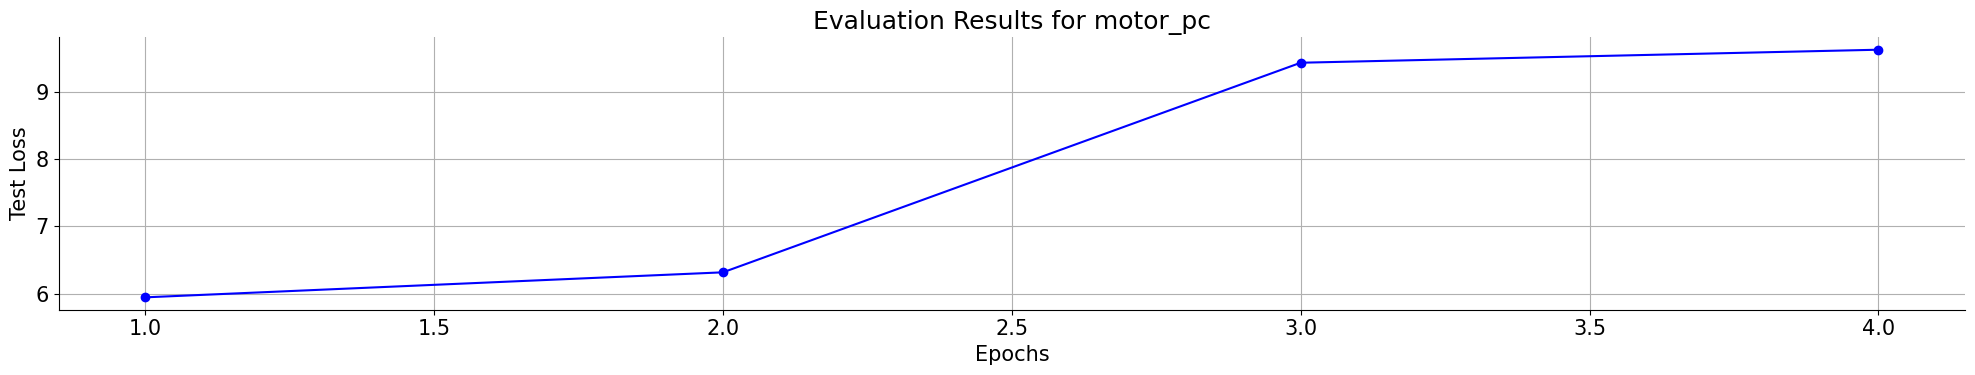

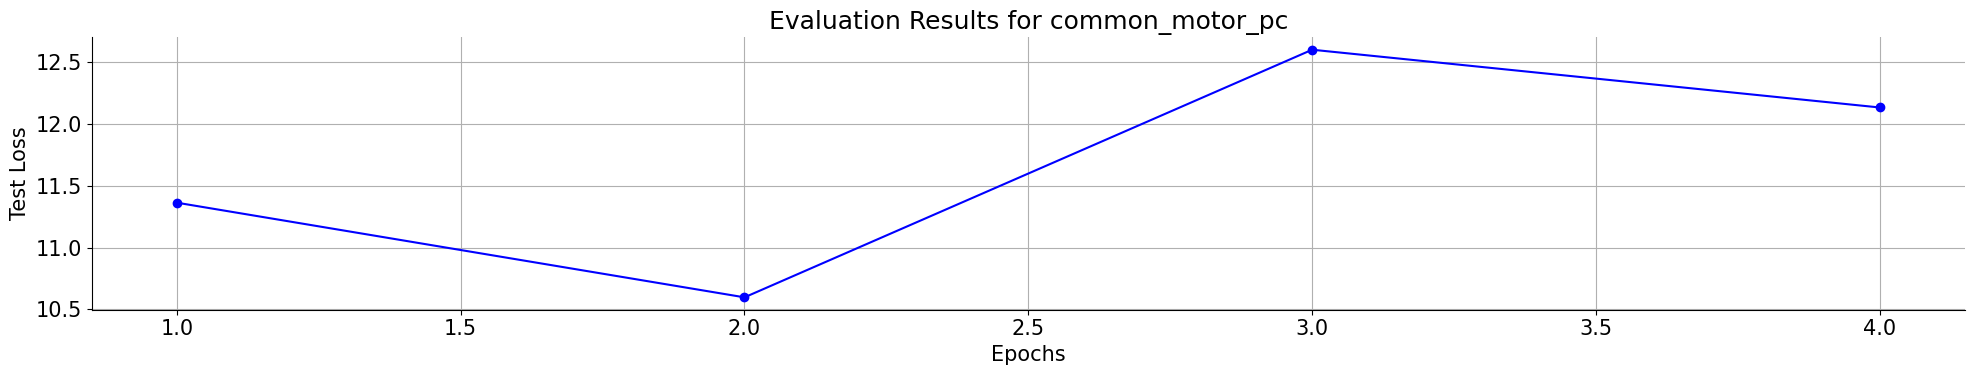

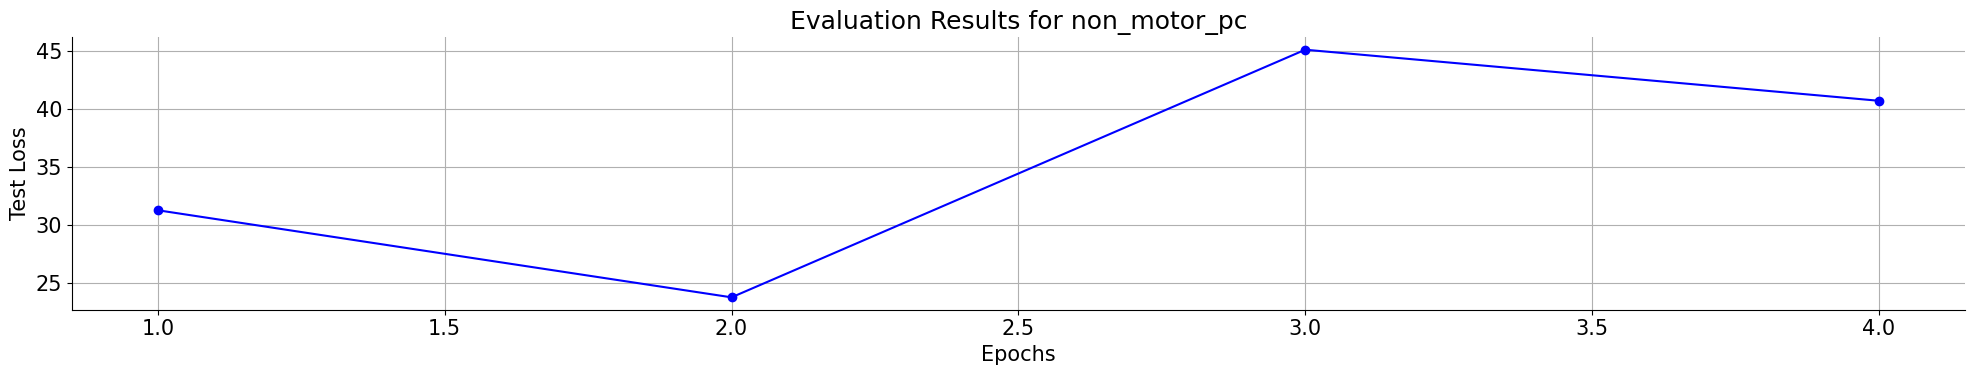

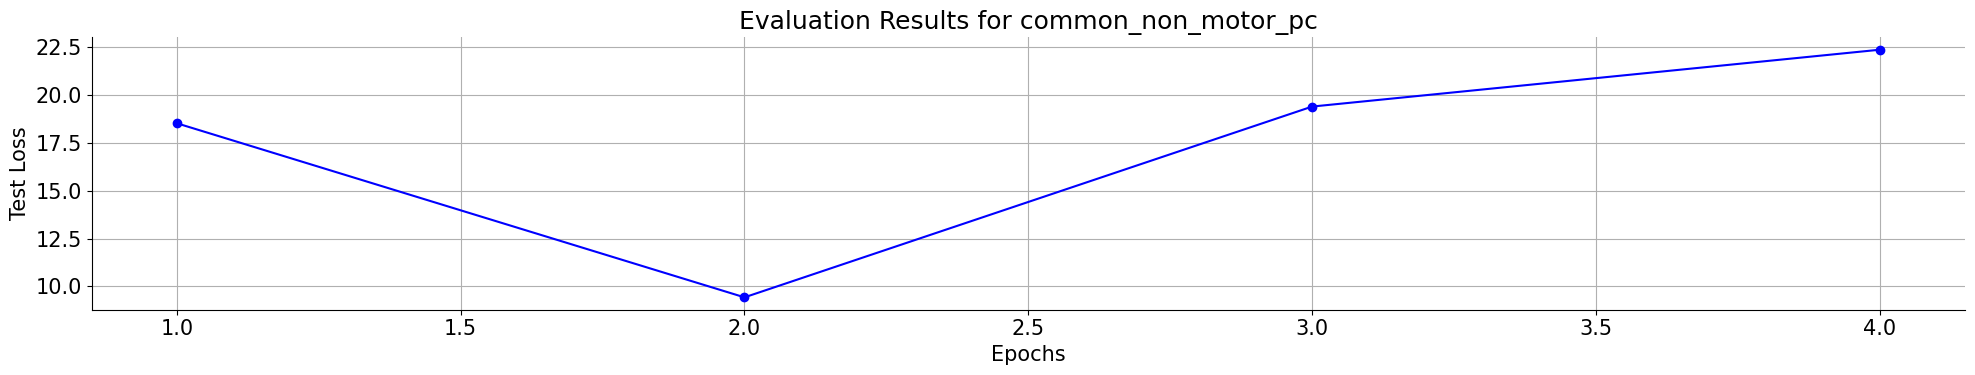

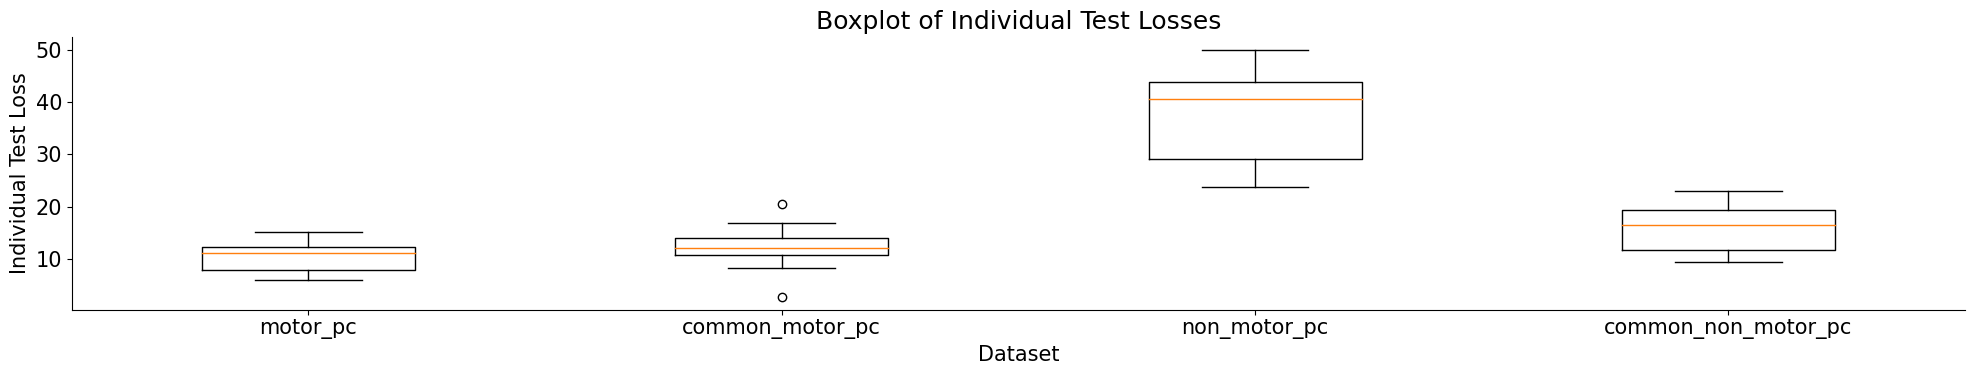

In [ ]:
# @title Plot of results and Boxplot of individual Test Losses

import matplotlib.pyplot as plt

losses = {}  # To store the losses for each dataset
num_epochs = 4
for name, (X, Y) in test_datasets.items():
    # Convert to tensors
    X, Y = torch.from_numpy(X).float(), torch.from_numpy(Y).float()

    # Create dataset and loader
    test_dataset = MyDataset(X, Y)
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    # Define the neural network and optimizer
    neuron_input = X.shape[1]  # Assuming X is a numpy array
    net = Net(neuron_input)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Evaluation loop
    net.eval()
    total_loss = 0.0
    individual_test_loss = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            individual_test_loss.append(loss.item())

    # Plotting the evaluation results
    epochs = range(1, num_epochs + 1)
    loss_values = individual_test_loss[:len(epochs)]
    plt.plot(epochs, loss_values, 'b-o')
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title(f'Evaluation Results for {name}')
    plt.grid(True)
    plt.show()

    # Store the losses
    losses[name] = individual_test_loss

# Create boxplot
plt.boxplot(losses.values(), labels=losses.keys())
plt.xlabel('Dataset')
plt.ylabel('Individual Test Loss')
plt.title('Boxplot of Individual Test Losses')
plt.show()

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Stringer"

In [ ]:
np.save('/content/drive/My Drive/Stringer/Boxplot_of_individual_test_losses.npy', losses.values)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo de Excel
df = pd.read_excel('/content/drive/MyDrive/random_states.xlsx')

# Preparar los datos para plt.boxplot
data = [df[col].dropna() for col in df if pd.api.types.is_numeric_dtype(df[col])]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar un boxplot para cada columna
ax.boxplot(data)

# Configurar las etiquetas del eje x para que correspondan a los nombres de las columnas
ax.set_xticklabels([col for col in df if pd.api.types.is_numeric_dtype(df[col])])

plt.title('Boxplot of Median Test Losses')
plt.show()


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/boxplot"

In [ ]:
np.save('/content/drive/My Drive/Stringer/Boxplot_medians', df)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')